$\newcommand{mb}[1]{\mathbf{#1}}$

<!-- dom:TITLE: Stiff differential equations.  -->
# Stiff differential equations. 
<!-- dom:AUTHOR: Anne Kværnø -->
<!-- Author: -->  
**Anne Kværnø**

Date: **Nov 7, 2018**

This note is a continuation of the note *Ordinary differential equations*. We
will use the codes from that note here as well. To improve the flow of the
arguments, these codes are included at the top, before the introduction. But run
the codes now, you will need them later.

In [1]:
%matplotlib inline

from numpy import *
from numpy.linalg import norm, solve
from matplotlib.pyplot import *
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
rcParams.update(newparams)

In [2]:
def euler(f, x, y, h):
    # One step of the Euler method
    y_next = y + h*f(x, y)
    x_next = x + h
    return x_next, y_next
# end of euler


def heun(f, x, y, h):
    # One step of Heun's method
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_next = y + 0.5*h*(k1+k2)
    x_next = x + h
    return x_next, y_next
# end of heun


def ode_solver(f, x0, xend, y0, h, method=euler):
    # Generic solver for ODEs
    #    y' = f(x,y), y(a)=y0
    # Input: f, the integration interval x0 and xend, 
    #        the stepsize h and the method of choice.  
    #   
    # Output: Arrays with the x- and the corresponding y-values. 
    
    # Initializing:
    y_num = array([y0])    # Array for the solution y 
    x_num = array([x0])    # Array for the x-values

    xn = x0                # Running values for x and y
    yn = y0 

    # Main loop
    while xn < xend - 1.e-10:            # Buffer for truncation errors        
        xn, yn = method(f, xn, yn, h)    # Do one step by the method of choice
        
        # Extend the arrays for x and y
        y_num = concatenate((y_num, array([yn])))
        x_num = append(x_num,xn)
        
    return x_num, y_num

In [3]:
def heun_euler(f, x, y, h):
    # One step with the pair Heun/Euler
    # Input: the function f, the present state xn and yn  and the stepsize h
    # Output: the solution x and y in the next step, error estimate, and the
    #         order p of Eulers method (the lowest order) 
    
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_next = y + 0.5*h*(k1+k2)      # Heuns metode (lokal ekstrapolasjon)
    x_next = x + h
    error_estimate = 0.5*h*norm(k2-k1)   # The 2-norm or the error estimate
    p = 1
    return x_next, y_next, error_estimate, p
# end of heun_euler



def ode_adaptive(f, x0, xend, y0, h0, tol = 1.e-6, method=heun_euler):
    # Adaptive solver for ODEs
    #    y' = f(x,y), y(x0)=y0
    # 
    # Input: the function f, x0, xend, and the initial value y0
    #        intial stepsize h, the tolerance tol, 
    #         and a function (method) implementing one step of a pair.
    # Ut: Array med x- og y- verdier. 
    
    y_num = array([y0])    # Array for the solutions y
    x_num = array([x0])    # Array for the x-values

    xn = x0                # Running values for  x, y and the stepsize h
    yn = y0 
    h = h0
    Maxcall = 100000        # Maximum allowed calls of method
    ncall = 0
    
    # Main loop
    while xn < xend - 1.e-10:               # Buffer for truncation error
        # Adjust the stepsize for the last step
        if xn + h > xend:                   
            h = xend - xn 
        
        # Gjør et steg med valgt metode
        x_try, y_try, error_estimate, p = method(f, xn, yn, h)
        ncall = ncall + 1
        
        if error_estimate <= tol:   
            # Solution accepted, update x and y
            xn = x_try    
            yn = y_try
            # Store the solutions 
            y_num = concatenate((y_num, array([yn])))
            x_num = append(x_num, xn)
        
        # else: The step rejectes and nothing is updated. 
        
        # Adjust the stepsize
        h = 0.8*(tol/error_estimate)**(1/(p+1))*h
        
        # Stop with a warning in the case of max calls to method
        if ncall > Maxcall:
            print('Maximum number of method calls')
            return x_num, y_num

    # Some diagnostic output
    print('Number of accepted steps = ', len(x_num)-1)
    print('Number of rejected steps = ', ncall - len(x_num)+1)
    return x_num, y_num

# Introduction
When an ODE is solved by an adaptive solver we will expect that more steps are required for stricter tolerances. 
More specific: The step size control is based on the assumption that the local error estimate $\mb{le}_{n+1}$ satisfies

$$
\|\mb{le}_{n+1}\| \approx Dh_n^{p+1} \approx \text{Tol},
$$

where $p$ is the order of the lowest order method, and $D$  is independent of the step size
$h$, $D$ depends on the solution point $(x,\mb{y})$, but it will not change much from one step to the next. 

By solving a problem by some adaptive method, using 
different tolerances, $\text{Tol}_1$ and $\text{Tol}_2$,  we will expect that the
corresponding step sizes $h_1$ and $h_2$ near the same arbitrary solution point
will behave like

$$
\text{Tol}_1 \approx D h_{1}^{p+1}, \qquad
  \text{Tol}_2 \approx D h_2^{p+1},
$$

so that

$$
\frac{h_1}{h_2} \approx \left( \frac{\text{Tol}_1}{\text{Tol}_2} \right)^{\frac{1}{p+1}} \approx \frac{N_2}{N_1}.
$$

where $N_1$ and $N_2$ are the total number of steps used for the two tolerances.

In the case of Heun-Euler $p=1$. By reducing the tolerance by a factor
$1/100$ we will expect that the number of steps increases by a factor of 10. 


**Numerical example 1:**
Given the following system of 2 ODEs

$$
\begin{align*}
  y_1' &= -2y_1 + y_2 + 2\sin(x), & y_1(0) &= 2, \\ 
  y_2' &= (a-1) y_1 - a y_2 + a\,\big(\cos(x)-\sin(x) \big), & y_2(0) &= 3,
\end{align*}
$$

where $a$ is some positive parameter. The exact solution, which is independent of the
parameter, is

$$
y_1(x) = 2 e^{-x} + \sin(x), \qquad y_2(x) = 2e^{-x} + \cos(x),
$$

check it yourself. Solve this problem with some adaptive ODE solver, for
instance the Heun-Euler scheme. 

Now try $\text{Tol}=10^{-2}, \, 10^{-4}, \, 10^{-6}$, and do the experiment with
two different values of the parameters, $a=2$ and $a=999$.


Tol = 1.0e-02
Number of accepted steps =  4992
Number of rejected steps =  3

Tol = 1.0e-04
Number of accepted steps =  4945
Number of rejected steps =  278

Tol = 1.0e-06
Number of accepted steps =  10628
Number of rejected steps =  3


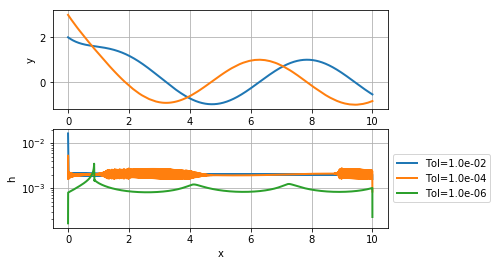

In [5]:
# Numerical example 1s
# Define the function
def f(x, y):
    a = 999
    dy = array([-2*y[0]+y[1]+2*sin(x),
                (a-1)*y[0]-a*y[1]+a*(cos(x)-sin(x))])
    return dy

# Initial values and integration interval 
y0 = array([2, 3])
x0, xend = 0, 10
h0 = 0.1

tol = 1.e-2
# Solve the ODE using different tolerances 
for n in range(3):
    print('\nTol = {:.1e}'.format(tol)) 
    x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol, method=heun_euler)
    
    if n == 0:
        # Plot the solution
        subplot(2,1,1)
        plot(x_num, y_num)
        ylabel('y')
        subplot(2,1,2)

    # Plot the step size control
    semilogy(x_num[0:-1], diff(x_num), label='Tol={:.1e}'.format(tol));
    
    tol = 1.e-2*tol         # Reduce the tolerance by a factor 0.01.
xlabel('x')
ylabel('h')
legend(loc='center left', bbox_to_anchor=(1, 0.5));

For $a=2$ the expected behaviour is observed. But the example $a=999$ requires much more steps, and 
the step size seems almost independent of the tolerance, at least for $\text{Tol}=10^{-2}, \, 10^{-4}$. 


The example above with $a=999$ is a typically example of a *stiff ODE*. When a stiff ODE is solved by some explicit
 adaptive method an unreasonable large number of steps is required, and this number seems independent of the tolerance.
In the remaining part of this note we will explain why this happens, and how we can overcome the problem. 
For simplicity, the discussion is restricted to
linear problems, but also nonlinear ODEs can, and often will be, stiff. 

**Exercise 1:**
Repeat the experiment on the Van der Pol equation

$$
\begin{align*}
    y_1' &= y_2, & y_1(0) &= 2,  \\ 
    y_2' &= \mu(1-y_1^2)y_2 - y_1, & y_2(0) &= 0.
   \end{align*}
$$

Use $\mu=2$, $\mu=5$ and $\mu=50$.



## Linear stability analysis

### Motivation

Given a system of $m$ differential equation of the form

$$
\mb{y}' = A \mb{y} + \mb{g}(x). \tag{*}
$$

Such systems have been discussed in Mathematics 3, and the technique for finding the exact solution will shortly be repeated here:

Solve the homogenous system $\mb{y}' = A \mb{y}$, that is, find the  eigenvalues $\lambda_i$ and the corresponding eigenvectors $\mb{v}_i$ satisfying

$$
A\mb{v}_i = \lambda_i \mb{v}_i, \qquad i=1,2,\dotsc,m. \tag{**}
$$

Assume that $A$ has a full set of linear independent eigenvectors
  $\mb{v}_i$. Let $V=[\mb{v}_1,\dots,\mb{v}_m]$, and
  $\Lambda = \text{diag}\{\lambda_1,\dotsc,\lambda_m\}.$  In this case $V$ is invertible and

$$
AV = V\Lambda \qquad \Leftrightarrow \qquad V^{-1}AV = \Lambda.
$$

The ODE (*) can be rewritten by

$$
V^{-1} \mb y' = V^{-1}A V V^{-1} \mb{y}+ V^{-1}\mb{g}(x).
$$

Let $\mb{z} = V^{-1}\mb{y}$ and $\mb{q}(x)=V^{-1}\mb{g}(x)$ such that the equation can be decoupled into a set of independent scalar differential equations

$$
\mb{z}' = \Lambda \mb{z} + \mb{q}(x) \qquad \Leftrightarrow \qquad
  z_i' = \lambda_i z_i + q_i(x), \quad i=1,\dotsc, m.
$$

The solution of such equations has been discussed in [Mathematics 1](https://wiki.math.ntnu.no/tma4100/tema/differentialequations). When these solutions are found, the exact solution is given by

$$
\mb{y}(x) = V \mb{z}(x),
$$

and possible integration constants are given by the initial values. 

As it turns out, the eigenvalues $\lambda_i$ are the key to understand the behaviour of the adaptive integrators. So we will discuss the stability properties of the very simplified linear test equation

$$
y' = \lambda y.
$$

For general problems the eigenvalues and the eigenvectors may be complex. In that case, the solutions will appear in complex conjugate pairs which can be combined to trigonometric functions. In this note, we will for simplicity only consider $\lambda \in \mathbb{R}$.  The discussion below is also relevant for nonlinear ODEs, $\mb{y}'(x)=\mb{f}(x,\mb{y}(x))$, in which case $\lambda$ is considered as an eigenvalue of the Jacobian $\mb{f}_{\mb{y}}$ of $\mb{f}$ with respect to $\mb{y}$.  

**Example 1:**
Return to the introductory example. The ODE can be written as

$$
\mb{y}' = A \mb{y} + \mb{g}(x),
$$

with

$$
A = \left(\begin{array}{cc} -2 & 1 \\ a-1 & -a \end{array}\right), \qquad
\mb{g}(x) = \left(\begin{array}{c}\sin(x) \\ a(\cos(x)-\sin(x)) \end{array}\right).
$$

The eigenvalues of the matrix $A$ are $\lambda_1 = -1$ and $\lambda_2 = -(a+1)$.
The general solution is given by

$$
\mb{y}(x) = c_1 \left(\begin{array}{c} 1 \\ 1 \end{array}\right) e^{-x}
             + c_2 \left(\begin{array}{c} -1 \\ a-1 \end{array}\right) e^{-(a+1)x}
             + \left(\begin{array}{c} \sin(x) \\ \cos(x) \end{array}\right).
$$

In the introductory example, the initial values were chosen such that $c_1=2$ and $c_2=0$. 
But for $a$ large, the term $e^{-(a+1)x}$ will go to 0 almost immediatly, even if $c_2\not=0$. 
It is still this term that creates problems for the numerical solution.

### Stability functions and stability intervals.

Given the linear test equation

$$
y' = \lambda y, \qquad y(0)=y_0, \qquad \lambda \in \mathbb{R}, \qquad \lambda < 0,
$$

with exact solution

$$
y(x) = e^{\lambda x} \, y_0.
$$

Since $\lambda < 0$ the solution $y(x) \rightarrow 0$ when $x\rightarrow \infty$.
We want a similar behaviour for the numerical solution, that is 
$ |y_{n}| \rightarrow 0$ when $n\rightarrow \infty$. But do we get it? 

One step of some Runge - Kutta method applied to the linear test equation can always be written as

$$
y_{n+1} = R(z)y_n, \qquad z=\lambda h.
$$

The function $R(z)$ is called the *stability function* of the method.

Taking the absolute value on each side of this expression, we see that there are three possible outcomes:

$$
\begin{align*}
|R(z)| & < 1 \quad \Rightarrow  & |y_{n+1}| & < |y_n| \quad \Rightarrow && y_n \rightarrow 0 &&\text{(stable)} \\ 
|R(z)| &= 1  \quad \Rightarrow   & |y_{n+1}| & = |y_n| \\ 
|R(z)| &> 1  \quad \Rightarrow   & |y_{n+1}| &> |y_n| \quad \Rightarrow  && |y_n| \rightarrow \infty && (\text{unstable})
\end{align*}
$$

The *stability interval* of a method is defined by

$$
\mathcal{S} = \{ z \in \mathbb{R} \; :\; |R(z)| \leq 1 \}.
$$

To get a stable numerical solution, we have to choose the step size $h$ such that $z=\lambda h\in \mathcal{S}$. 

**Numerical example 2:**
Euler's method applied to the linear test equation is

$$
y_{n+1} = y_n + h\lambda y_n = (1+h\lambda)y_n,
$$

so the stability function $R(z)$ and the stability interval $\mathcal{S}$ is

$$
R(z) = 1+z, \qquad \mathcal{S}=[-2,0].
$$

Next, solve the introductory problem

$$
\mb{y}' = \left(\begin{array}{cc} -2 & 1 \\ a-1 & -a \end{array}\right) \mb{y} +
\left(\begin{array}{c}\sin(x) \\ a(\cos(x)-\sin(x)) \end{array}\right),
\qquad \mb{y}(0) = \left(\begin{array}{c} 2 \\ 3 \end{array}\right), \qquad a>0.
$$

by Euler's method. We know that the eigenvalues of the matrix $A$ are

$\lambda_1 = -1$ and $\lambda_2 = -(1+a)$.

For the numerical solution to be stable for both eigenvalues, we have to require that

$$
h \leq \frac{2}{1+a}.
$$

Try $a=9$ and $a=999$. Choose step sizes a little bit over and under the stability boundary, and you can experience that the result is sharp. If $h$ is just a tiny bit above, you may have to increase the interval of integration to see the unstable solution.

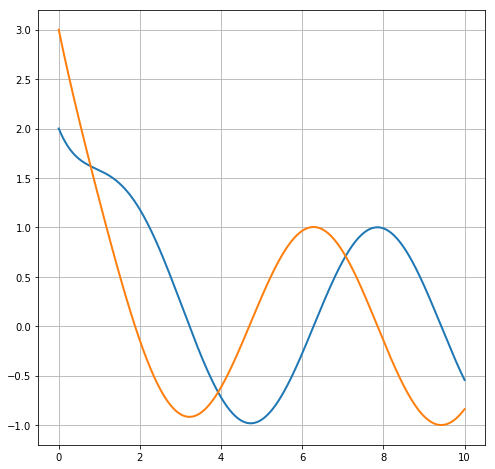

In [29]:
# Numerical example 2s
def f(x, y):
    # y' = f(x,y) = A*y+g(x)
    a = 999
    dy = array([-2*y[0]+y[1]+2*sin(x),
                (a-1)*y[0]-a*y[1]+a*(cos(x)-sin(x))])
    return dy

# Startverdier og integrasjonsintervall 
y0 = array([2, 3])
x0, xend = 0, 10
h = 0.0001

x_num, y_num = ode_solver(f, x0, xend, y0, h, method=euler)
plot(x_num, y_num);

It is the term corresponding to the eigenvalue $\lambda_2=-(a+1)$ which makes the solution unstable. And the solution oscillate since $R(z)<-1$ for $h>2/(1+a)$.


**Exercise 2:**
1. Find the stability function and the stability interval for Heun's method.

2. Repeat the experiment in Example 2 using Heun's mehod.

**NB!** Usually the error estimation in adaptive methods will detect the unstability and force the step size to stay inside or near the stability interval. This explains the behaviour of the experiment in the introduction of this note. 

# $A(0)$-stable methods.

In an ideal world, we would prefer the stability interval to satisfy $\mathcal S \supset \mathbb{R}^-$, such that the method 
is stable for all $\lambda <0$ and for all $h$. Such methods are called $A(0)$-stable. For all explicit methods, like Euler's
 and Heun's, the stability function will be a polynomial, and $|R(z)|\rightarrow \infty$ as $z\rightarrow -\infty$. Explicit
 methods can not be $A(0)$-stable. We have to search among implicit methods. The simplest of those is the implicit, 
or backward Euler's method, given by

$$
y_{n+1} = y_n + hf(x_{n+1}, y_{n+1}).
$$

Applied to the linear test equation $y'=\lambda y$:

$$
y_{n+1} = y_n + h\lambda y_{n+1} \qquad \Rightarrow \qquad
y_{n+1} = \frac{1}{1-h\lambda}
\qquad \Rightarrow \qquad R(z) = \frac{1}{1-z}.
$$

The method is $A(0)$-stable since 
$|R(z)|\leq 1$ for all $z\leq 0$.


## Implementation of implicit Euler's method
For simplicity, we will only discuss the implementation of implicit Euler's method for linear systems of the form

$$
\mb{y}' = A\mb{y} + \mb{g}(x),
$$

where $A$ is a constant matrix. In this case, one step of implicit Euler is given by

$$
\mb{y}_{n+1} = \mb{y}_n + hA\mb{y}_{n+1} + h\mb{g}(x_{n+1}).
$$

A linear system

$$
(I - hA)\mb{y}_{n+1} = \mb{y}_n + h \mb{g}(x_{n+1})
$$

has to be solved with respect to $\mb{y}_{n+1}$ for each step. 

In the implementation below, the right hand side of the ODE is implemented as a
function `rhs`, returning the matrix $A$ and the vector $\mb{g}(x)$ for each
step. The function `implicit_euler` does one step with implicit Euler. It has
the same interface as the explicit method, so that the function `ode_solve` can be used as before.

In [17]:
def implicit_euler(rhs, x, y, h):
    # One step of the implicit Euler's method on the problem 
    #              y' = Ay + g(x)
    # The function rhs should return A and g for each x 
    #     A, gx = rhs(x)
    A, gx = rhs(x+h)
    d = len(gx)                  # The dimension of the system
    M = eye(d) - h*A             # M = I-hA
    b = y + h*gx                 # b = y + hf(x)
    y_next = solve(M, b)         # Solve M y_next = b
    x_next = x+h
    return x_next, y_next

**Numerical example 3:**
Solve the test equation with

$$
A = \left(\begin{array}{cc} -2 & 1 \\ a-1 & -a \end{array}\right), \qquad
\mb{g}(x) = \left(\begin{array}{c}\sin(x) \\ a(\cos(x)-\sin(x)) \end{array}\right),
$$

by implicit Euler. Choose $a=2$ and  $a=999$, and try different stepsizes like $h=0.1$ and $h=0.01$. Are there any stability issues in this case?

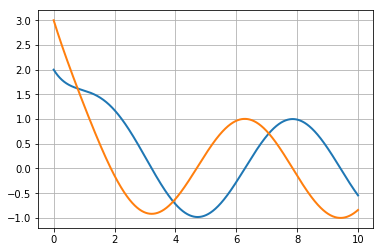

In [22]:
# Numerical example 3s
def rhs(x):
    # The right hand side (rhs) of y' = Ay + g(x)
    a = 999
    A = array([[-2, 1],[a-1, -a]])
    gx = array([2*sin(x), a*(cos(x)-sin(x))])
    return A, gx

# Initial values and integration interval 
y0 = array([2, 3])
x0, xend = 0, 10
h = 0.001             # Initial stepsize

x_num, y_num = ode_solver(rhs, x0, xend, y0, h, method=implicit_euler)
plot(x_num, y_num);

**Exercise 2:**
The trapezoidal rule is an implicit method which for a general ODE $\mb{y}'(x)=f(x,\mb{y}(x))$ is given by

$$
\mb{y}_{n+1} = \mb{y}_{n} + \frac{h}{2}\bigg( \mb{f}(x_n,\mb{y}_n) + \mb{f}(x_{n+1},\mb{y}_{n+1})\bigg).
$$

1. Find the stability function to the trapezoidal rule, and prove that it is $A(0)$-stable. 

2. Implement the method, and repeat the experiment above. 

## Adaptive methods.
Implicit Euler is a method of order 1, and the trapezoidal rule of order 2. Thus, these can be used for error estimation:
Do one step with each of the methods, use the difference between the solutions as an error estimate, and use the solution 
from the trapezoidal rule to advance the solution. This has been implemented in the function `trapezoidal_ieuler`. 
The interface is as for the embedded pair `heun_euler`, so the adaptive solver `ode_adaptive` can be used as before.

In [23]:
def trapezoidal_ieuler(rhs, x, y, h):
    # One step with the combination of implicit Euler and the trapezoidal rule
    # for ODEs on the form
    #              y' = Ay + f(x)
    # The function rhs should return A and g for each x:
    #     A, fx = rhs(x)
    A, gx1 = rhs(x+h)
    A, gx0 = rhs(x)
    d = len(gx1)
    
    # One step with implicit Euler
    M = eye(d)-h*A
    b = y + h*gx1
    y_ie = solve(M, b)
    
    # One step with the trapezoidal rule
    M = eye(d)-0.5*h*A
    b = y + 0.5*h*dot(A,y) + 0.5*h*(gx0+gx1)
    y_next = solve(M, b)                       # The solution in the next step
    
    error_estimate = norm(y_next-y_ie)
    x_next = x + h
    p = 1                                       # The order
    return x_next, y_next, error_estimate, p

**Numerical example 4:**
Repeat the experiment from the introduction, using `trapezoidal_euler`.


Tol = 1.0e-02
Number of accepted steps =  71
Number of rejected steps =  3

Tol = 1.0e-04
Number of accepted steps =  835
Number of rejected steps =  1

Tol = 1.0e-06
Number of accepted steps =  8596
Number of rejected steps =  1


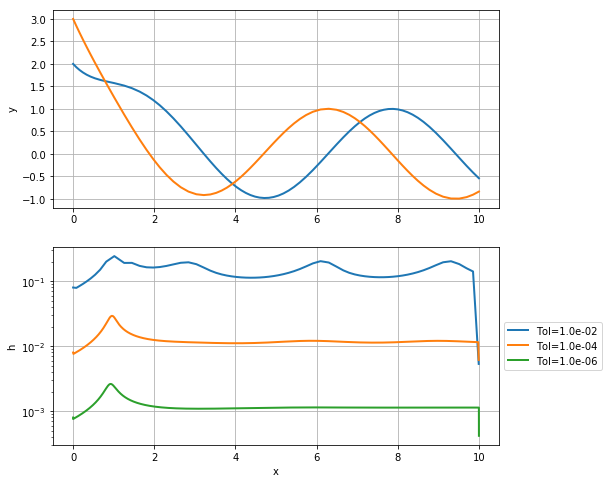

In [24]:
# Numerical example 4s
def rhs(x):
    # The right hand side of the ODE y' = Ay+g(x)
    a = 9
    A = array([[-2, 1],[a-1, -a]])
    gx = array([2*sin(x), a*(cos(x)-sin(x))])
    return A, gx

# Initial values and integration interval
y0 = array([2, 3])
x0, xend  = 0, 10
h0 = 0.1                    # Initial stepsize

tol = 1.e-2                 # Tolerance

rcParams['figure.figsize'] = 8, 8
# Solve the equation by different stepsizes. 
for n in range(3):
    print('\nTol = {:.1e}'.format(tol)) 
    x_num, y_num = ode_adaptive(rhs, x0, xend, y0, h0, tol, method=trapezoidal_ieuler)
    
    if n==0:
        # Plot the solution
        subplot(2,1,1)
        plot(x_num, y_num)
        ylabel('y')
        subplot(2,1,2)

    # Plot the step size sequence
    semilogy(x_num[0:-1], diff(x_num), label='Tol={:.1e}'.format(tol));
    
    tol = 1.e-2*tol         # Reduce the tolerance by a factor 1/100

# Decorations
xlabel('x')
ylabel('h')
legend(loc='center left', bbox_to_anchor=(1, 0.5));

We observe that there are no longer any step size restriction because of
stability. The algorithm behaves as expected.

**Comment:**
Implicit methods can of course also be applied for nonlinear ODEs. Implicit Euler's method will be

$$
\mb{y}_{n+1} = \mb{y}_n + h\mb{f}(x,\mb{y}_{n+1}),
$$

which is a nonlinear system which has to be solved for each step. Similar for the trapezoidal rule. 
Usually these equations are solved by Newton's method or some simplification of it.  


**Summary.**

Linear test equation:

$$
y' = \lambda y, \qquad \lambda <0.
$$

Stability function $R(z)$, given by the method applied to the test problem:

$$
y_{n+1} = R(z)y_n, \qquad z=\lambda h.
$$

Stability interval $\mathcal{S}$:

$$
\mathcal{S} = \{z\in \mathbb{R}, \quad |R(z)| \leq 1\}.
$$

$A(0)$-stability:

$$
\mathcal{S} \supset \mathbb{R}^{-},
$$

which is the same as

$$
|R(z)| \leq 1 \qquad \text{for all } z \leq 0.
$$